In [2]:
import cv2

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [3]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
image_gen = ImageDataGenerator(#rotation_range=30, # rotate the image 30 degrees
                               #width_shift_range=0.1, # Shift the pic width by a max of 10%
                               #height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               #shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               #zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               #fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [4]:
#image_gen.flow_from_directory('positions/train')
image_gen.flow_from_directory('actions/train')

Found 294 images belonging to 4 classes.


In [5]:
image_gen.flow_from_directory('actions/test')

Found 77 images belonging to 4 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [5]:
# width,height,channels
image_shape = (150,150,3)

# Creating the Model

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [8]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, not binary!
model.add(Dense(4))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', #not binary for the poses
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

### Training the Model

In [10]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('actions/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical') #catagoricalnfor the poses

Found 294 images belonging to 4 classes.


In [12]:
#print(next(train_image_gen))
#train_image_gen.shape

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

In [11]:
test_image_gen = image_gen.flow_from_directory('actions/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 77 images belonging to 4 classes.


In [12]:
train_image_gen.class_indices

{'fall': 0, 'sit': 1, 'stand': 2, 'walk': 3}

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
results = model.fit_generator(train_image_gen,epochs=10,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/10
150/150 [==============================] - 97s 647ms/step - loss: 0.2215 - acc: 0.9299 - val_loss: 2.9458 - val_acc: 0.4286
Epoch 2/10
150/150 [==============================] - 96s 642ms/step - loss: 0.0769 - acc: 0.9772 - val_loss: 3.7612 - val_acc: 0.4545
Epoch 3/10
150/150 [==============================] - 93s 622ms/step - loss: 0.0353 - acc: 0.9892 - val_loss: 4.6552 - val_acc: 0.5325
Epoch 4/10
150/150 [==============================] - 104s 691ms/step - loss: 0.0233 - acc: 0.9925 - val_loss: 5.1413 - val_acc: 0.5325
Epoch 5/10
150/150 [==============================] - 99s 659ms/step - loss: 0.0272 - acc: 0.9937 - val_loss: 5.5583 - val_acc: 0.5195
Epoch 6/10
150/150 [==============================] - 96s 643ms/step - loss: 0.0099 - acc: 0.9979 - val_loss: 5.9112 - val_acc: 0.5195
Epoch 7/10
150/150 [==============================] - 97s 644ms/step - loss: 0.0167 - acc: 0.9971 - val_loss: 5.3903 - val_acc: 0.5584
Epoch 8/10
150/150 [==============================] - 

In [16]:
model.save('model0.h5')

# Evaluating the Model

In [17]:
results.history['acc']

[0.9288793102420609,
 0.9771551723624098,
 0.9888412017167382,
 0.9922413793103448,
 0.9935344827586207,
 0.9978354978354979,
 0.9969827586206896,
 0.9982832618025751,
 0.9956896551724138,
 0.997413793052065]

In [19]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


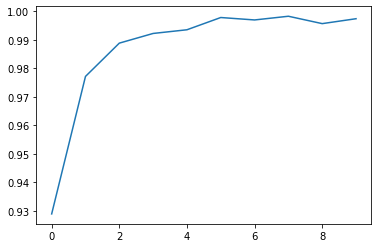

In [20]:
plt.plot(results.history['acc'])

In [7]:
from keras.models import load_model

In [8]:
new_model = load_model('model0.h5')

# Predicting on new images

In [21]:
train_image_gen.class_indices

{'fall': 0, 'sit': 1, 'stand': 2, 'walk': 3}

In [19]:
v = cv2.imread('POSE3.jpg')
v.shape

(802, 350, 3)

In [9]:
import numpy as np
from keras.preprocessing import image

pose_file = 'testing/fall4.jpg'

pose = image.load_img(pose_file, target_size=(150, 150))

pose = image.img_to_array(pose)

pose = np.expand_dims(pose, axis=0) #so the network can think its a batch of one image
pose = pose/255

In [54]:
prediction_prob = new_model.predict(pose)
new_model.predict_classes(pose) 
                               

array([2])

In [22]:
# Output prediction
print(prediction_prob) #how sure is it that the image belongs to the array it chose 

[[2.3526377e-23 9.9999774e-01 4.9228033e-18 9.8221578e-12 1.7766470e-19
  1.5273822e-19 3.9252950e-18 4.9790081e-18]]


In [10]:
import numpy as np
from keras.preprocessing import image
#function to classify a pose
def predictPose(imageName):
    #resize the image since the model is trained with 150 by 150 images
    pose = image.load_img(imageName, target_size=(150,150))
    pose = image.img_to_array(pose)
    pose = np.expand_dims(pose, axis=0)
    pose = pose/255
    
    #actual classification
    prediction_prob = new_model.predict(pose)
    #returns which pose
    poseNumber = new_model.predict_classes(pose)
    #print(prediction_prob)
    return poseNumber[0]+1
    
    

In [11]:
import time
import numpy as np
from PIL import Image
import os
import sys

In [12]:
def getAllImages(rootdir):
    """Gets all of the images in a folder and runs them through OpenPose.
    You just need to run this function with the folder of pose images"""
    path, dirs, files = next(os.walk(rootdir))
    file_count = len(files) - 1
    poseList = []
    action = 0
    actionList = []
    i = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # print os.path.join(subdir, file)
            filepath = subdir + os.sep + file

            if filepath.endswith(".jpg"):
                i += 1
                #printProgressBar(i + 1, file_count, prefix='Progress:', suffix='Complete', length=50)
                print("processing image "+ str(i))
                action = predictPose(filepath)
                print(action)
                actionList.append(action)
    return actionList
                

In [13]:
t = time.time()
print("Time at start: " + str((time.time() - t)))
result = getAllImages('testing/fall')
print("Time taken: " + str((time.time() - t)))

Time at start: 4.887580871582031e-05
processing image 1
2
processing image 2
3
processing image 3
4
processing image 4
3
processing image 5
3
processing image 6
4
processing image 7
1
processing image 8
1
processing image 9
1
processing image 10
2
processing image 11
1
processing image 12
4
processing image 13
1
processing image 14
2
processing image 15
4
processing image 16
3
processing image 17
1
processing image 18
2
processing image 19
1
processing image 20
4
processing image 21
2
processing image 22
2
processing image 23
1
processing image 24
1
processing image 25
1
processing image 26
1
processing image 27
2
processing image 28
2
processing image 29
4
processing image 30
4
processing image 31
1
processing image 32
1
processing image 33
4
processing image 34
2
processing image 35
1
processing image 36
1
processing image 37
3
processing image 38
3
processing image 39
1
processing image 40
2
processing image 41
2
processing image 42
4
processing image 43
2
processing image 44
2
proc

In [20]:

fall = 0
walk = 0
stand = 0
sit = 0
size = len(result)
for i in result:
    if i == 1:
        fall += 1
    elif i == 2:
        sit += 1
    elif i == 3:
        stand += 1
    elif i == 4:
        walk += 1
    else:
        print("error")
        
print('fall:', fall, (fall/size)*100)
print('sit:', sit, (sit/size)*100)
print('stand:', stand, (stand/size)*100)
print('walk:', walk, (walk/size)*100)

fall: 76 50.0
sit: 39 25.657894736842106
stand: 14 9.210526315789473
walk: 23 15.131578947368421


In [26]:
#sample run
print(predictPose('POSE22.jpg'))

2


In [41]:
import os.path
def detectAllPlayers():
    path = 'players/player'
    detected_poses = []
    player = 0
    pose = 0
    #to check if the player exists
    playerExists = os.path.isfile(path+str(player)+'.jpg') 

    while playerExists:
        pose = predictPose(path+str(player)+'.jpg')
        detected_poses.append(pose)
        player +=1
        playerExists = os.path.isfile(path+str(player)+'.jpg')   

    return detected_poses

In [42]:

for player in range(len(detectAllPlayers())):
    print("Player", player, "is displaying pose", detected_poses[player])

Player 0 is displaying pose 2
Player 1 is displaying pose 6
Player 2 is displaying pose 2


In [47]:
#game play
def simonSays(correctPose):
    playerPoses = detectAllPlayers()
    for player in range(len(playerPoses)):
        if playerPoses[player] == correctPose:
            print("Player", player, "congrats! You've done the pose correctly")
        else:
            print("Player", player, "uh-oh! You've done the pose incorrectly")
    


In [48]:
simonSays(2)

Player 0 congrats! You've done the pose correctly
Player 1 uh-oh! You've done the pose incorrectly
Player 2 congrats! You've done the pose correctly
